In [1]:
#required moduls
import numpy as np
import cv2
import PIL.Image as Image
import os
import pathlib
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

In [2]:
#settings
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [3]:
train_dir="C:\\Users\\101\\hussein\\rasenet\\classifier_intersections\\simulated_intersections"
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dir="C:\\Users\\101\\hussein\\rasenet\\classifier_intersections\\test_sets\\A"
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

val_dir="C:\\Users\\101\\hussein\\rasenet\\classifier_intersections\\cross_validation_sets\\BCD"
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)



Found 10000 files belonging to 4 classes.
Found 500 files belonging to 4 classes.
Found 1500 files belonging to 4 classes.


In [4]:
#improve perf
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(0.2),])

In [6]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input


In [7]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [8]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [9]:
base_model.trainable = False


In [10]:
#effiecient arch
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [12]:
prediction_layer = tf.keras.layers.Dense(4,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [13]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [15]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [16]:
len(model.trainable_variables)


2

In [17]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(validation_dataset)

47/47 [==============================] - 71s 1s/step - loss: 2.2850 - accuracy: 0.2667


In [18]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.28
initial accuracy: 0.27


In [19]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=test_dataset)

Epoch 1/5
313/313 [==============================] - 869s 3s/step - loss: 1.0436 - accuracy: 0.5798 - val_loss: 1.2521 - val_accuracy: 0.4560
Epoch 2/5
313/313 [==============================] - 635s 2s/step - loss: 0.4807 - accuracy: 0.8437 - val_loss: 1.2451 - val_accuracy: 0.4920
Epoch 3/5
313/313 [==============================] - 596s 2s/step - loss: 0.3383 - accuracy: 0.8990 - val_loss: 1.2730 - val_accuracy: 0.5100
Epoch 4/5
313/313 [==============================] - 583s 2s/step - loss: 0.2683 - accuracy: 0.9239 - val_loss: 1.2922 - val_accuracy: 0.5040
Epoch 5/5
313/313 [==============================] - 575s 2s/step - loss: 0.2203 - accuracy: 0.9390 - val_loss: 1.3141 - val_accuracy: 0.5140


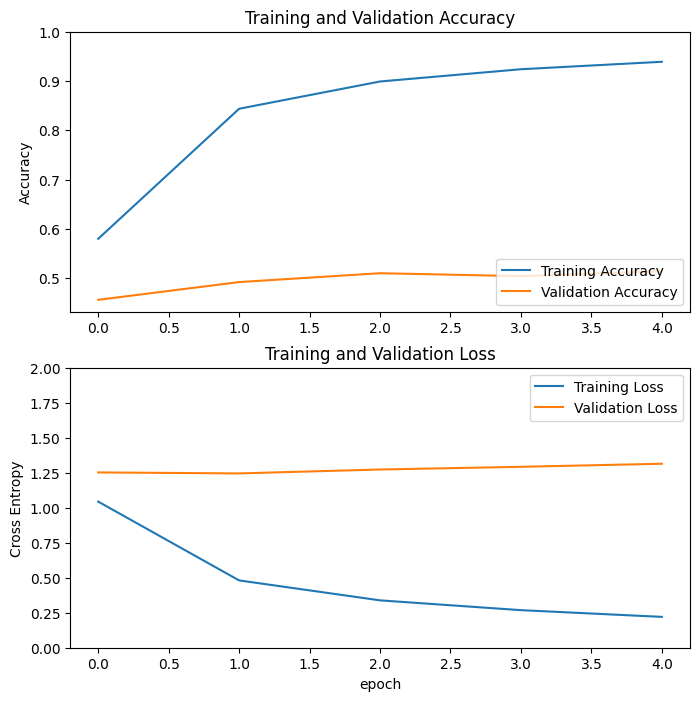

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('test_a')
plt.show()

In [21]:
base_model.trainable = True


In [22]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 118

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [23]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [25]:
len(model.trainable_variables)


70

In [26]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(validation_dataset ,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)

Epoch 5/15
47/47 [==============================] - 171s 3s/step - loss: 0.6378 - accuracy: 0.7540 - val_loss: 0.5687 - val_accuracy: 0.7980
Epoch 6/15
47/47 [==============================] - 168s 4s/step - loss: 0.2649 - accuracy: 0.8980 - val_loss: 0.6207 - val_accuracy: 0.8020
Epoch 7/15
47/47 [==============================] - 169s 4s/step - loss: 0.1695 - accuracy: 0.9440 - val_loss: 0.4327 - val_accuracy: 0.8700
Epoch 8/15
47/47 [==============================] - 169s 4s/step - loss: 0.1401 - accuracy: 0.9513 - val_loss: 0.4031 - val_accuracy: 0.8760
Epoch 9/15
47/47 [==============================] - 169s 4s/step - loss: 0.1048 - accuracy: 0.9593 - val_loss: 0.5277 - val_accuracy: 0.8380
Epoch 10/15
47/47 [==============================] - 169s 4s/step - loss: 0.0775 - accuracy: 0.9733 - val_loss: 0.4897 - val_accuracy: 0.8920
Epoch 11/15
47/47 [==============================] - 168s 4s/step - loss: 0.0788 - accuracy: 0.9740 - val_loss: 0.5841 - val_accuracy: 0.8660
Epoch 12/15

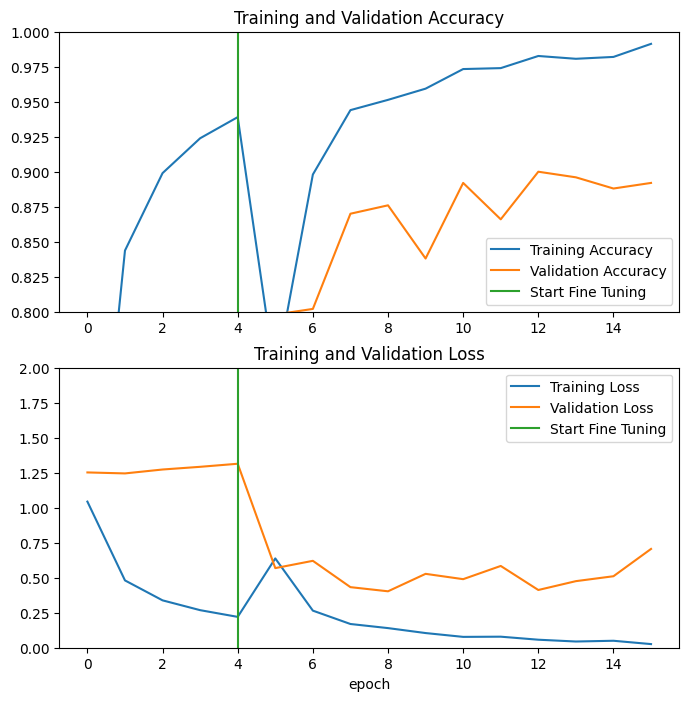

In [27]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('train_on_bcd_test_on_a_with_fine_tuning')
plt.show()

In [28]:
train_dir="C:\\Users\\101\\hussein\\rasenet\\classifier_intersections\\simulated_intersections"
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dir="C:\\Users\\101\\hussein\\rasenet\\classifier_intersections\\test_sets\\A"
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

val_dir="C:\\Users\\101\\hussein\\rasenet\\classifier_intersections\\cross_validation_sets\\BCD"
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)



Found 10000 files belonging to 4 classes.
Found 500 files belonging to 4 classes.
Found 1500 files belonging to 4 classes.


16/16 [==============================] - 27s 2s/step


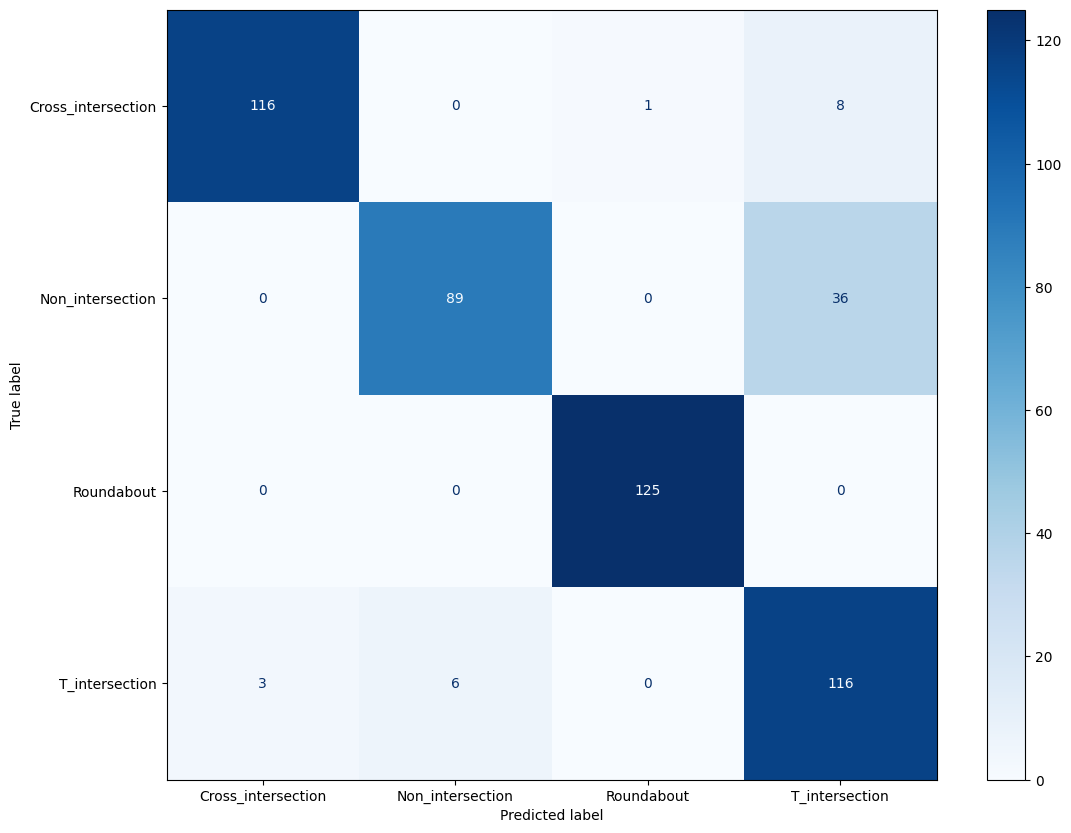

In [29]:
val_images =[]
true_labels = []
for image, label in test_dataset.unbatch():
    val_images.append(image)
    true_labels.append(label)
val_images = np.array(val_images)
true_labels = np.array(true_labels)  

predictions = model.predict(val_images)
predict_labels = predictions.argmax(axis=1)


intersections = test_dataset.class_names
cm = confusion_matrix(true_labels, predict_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=intersections)
fig, ax = plt.subplots(figsize=(13,10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.savefig('train_on_bcd_val_on_a_with_con_matrix')
plt.show()

In [30]:
loss, acc = model.evaluate(val_images, true_labels, verbose=2)
print("Accuracy: {:5.2f}%".format(100 * acc))

16/16 - 24s - loss: 0.7057 - accuracy: 0.8920 - 24s/epoch - 1s/step
Accuracy: 89.20%


In [31]:
file=open("C:\\Users\\101\\hussein\\rasenet\\acc\\BCD\\acc.txt",'a')
file.write('model spec : \n')
file.write("accuracy of the model is : "+str(acc*100)+'\n')
file.write('loss of the model is : '+str(loss))
file.close()

# # save model
model.save("C:\\Users\\101\\hussein\\rasenet\\acc\\BCD\\model.h5")


